# Regression Models with Pycaret

#### Get information

In [1]:
from pycaret.regression import *

In [2]:
# load the dataset from pycaret
from pycaret.datasets import get_data
dataset = get_data('diamond')

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


#### EDA

In [3]:
# !pip install pandas-profiling
# !pip list

In [4]:
dataset = get_data('diamond', profile=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (5400, 8)
Unseen Data For Predictions (600, 8)


#### Preprocessing

In [6]:
# !pip list

In [7]:
# !pip install mlflow

In [14]:
import os
os.getcwd()

'C:\\Users\\WMYFHCK\\Documents\\github_personal\\Course+material\\Entrega\\2. Automating the ML Model Cycle'

In [23]:
# For logging to work with mlflow, one has to change the path in meta.yml file in mlruns folder 
# Copy the above path and append the mlruns directory path

In [25]:
# initialize setup

exp_reg102 = setup(data = data, target = 'Price', 
                   session_id=123,
                   normalize = True, 
                   transformation = True, transform_target = True, 
                   rare_to_value = 0.05,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
                  bin_numeric_features = ['Carat Weight'],
                  log_experiment = True, experiment_name = 'diamond1',
                  verbose=False)

#### Model Training

In [26]:
best_model = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1669.9660,6375439.5238,2500.3723,0.9375,0.2240,0.1847,0.2520
gbr,Gradient Boosting Regressor,1737.6510,7032783.3658,2611.4470,0.9305,0.2254,0.1905,0.2910
rf,Random Forest Regressor,1782.9354,7562908.5329,2730.8242,0.9256,0.2424,0.1938,0.3490
et,Extra Trees Regressor,1934.6340,9478080.7982,3060.6766,0.9061,0.2623,0.2057,0.3630
dt,Decision Tree Regressor,1958.1817,10004086.6635,3150.1290,0.9005,0.2636,0.2068,0.2080
huber,Huber Regressor,2475.4675,14048592.6577,3724.9835,0.8618,0.2791,0.2457,0.2050
ridge,Ridge Regression,2539.5880,14482719.5883,3781.7478,0.8576,0.2764,0.2408,0.1910
br,Bayesian Ridge,2543.2311,14551919.1626,3790.5845,0.8569,0.2765,0.2408,0.2090
lr,Linear Regression,2549.8724,14752100.9823,3815.0583,0.8551,0.2769,0.2411,0.6960
ada,AdaBoost Regressor,2765.7058,25634838.3155,4995.6865,0.7525,0.2955,0.2298,0.2950


In [27]:
tuned_best = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4319.5830,60120383.1118,7753.7335,0.3399,0.4351,0.3281
1,4904.6526,96919983.2673,9844.7947,0.2572,0.4826,0.3679
2,4664.4244,73992020.3137,8601.8614,0.3214,0.4710,0.3798
3,4496.2940,59351341.3712,7703.9822,0.3452,0.4493,0.3401
4,4056.3383,50226831.9594,7087.0891,0.3735,0.4423,0.3530
5,4664.9298,83124648.0235,9117.2720,0.2906,0.4674,0.3597
6,4809.1151,73729320.8209,8586.5779,0.3073,0.4726,0.3590
7,4244.7974,53585644.9779,7320.2216,0.3223,0.4467,0.3455
8,4635.2538,69548612.9951,8339.5811,0.3170,0.4584,0.3427


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


#### Individual model training

In [28]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1678.2105,5447110.8380,2333.9046,0.9402,0.2286,0.1862
1,1847.7449,10082280.4520,3175.2607,0.9227,0.2277,0.1906
2,1695.7549,5279329.7646,2297.6792,0.9516,0.2364,0.1990
3,1651.4778,4882819.6043,2209.7103,0.9461,0.2128,0.1760
4,1702.9998,6187406.3738,2487.4498,0.9228,0.2303,0.1932
5,1733.3395,7181096.3976,2679.7568,0.9387,0.2189,0.1857
6,1802.1759,7521631.1279,2742.5592,0.9293,0.2294,0.1851
7,1252.0478,3454274.0051,1858.5677,0.9563,0.1907,0.1472
8,1664.8319,8028096.9159,2833.3897,0.9212,0.2229,0.1812


In [9]:
import numpy as np
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }

tuned_lightgbm = tune_model(lightgbm, 
                            custom_grid = lgbm_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,822.6400,2569287.7739,1602.8998,0.9718,0.0868,0.0641
1,1008.9226,6724757.6372,2593.2138,0.9485,0.0860,0.0618
2,815.8761,2461914.7737,1569.0490,0.9774,0.0857,0.0628
3,805.5570,2066452.6946,1437.5162,0.9772,0.0805,0.0620
4,814.8100,2151031.1608,1466.6394,0.9732,0.0904,0.0664
5,881.7793,4766151.7412,2183.1518,0.9593,0.0838,0.0608
6,951.9875,4092100.1761,2022.8940,0.9616,0.0906,0.0662
7,872.9769,3230168.8544,1797.2671,0.9592,0.0889,0.0654
8,790.5395,2393344.9164,1547.0439,0.9765,0.0801,0.0609


### Evaluate model

In [29]:
# check the residuals of trained model
plot_model(tuned_best, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

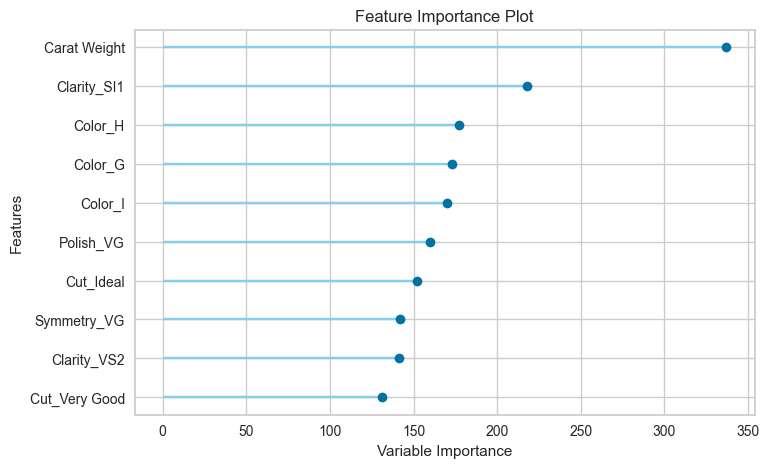

In [30]:
# check feature importance
plot_model(tuned_best, plot = 'feature')

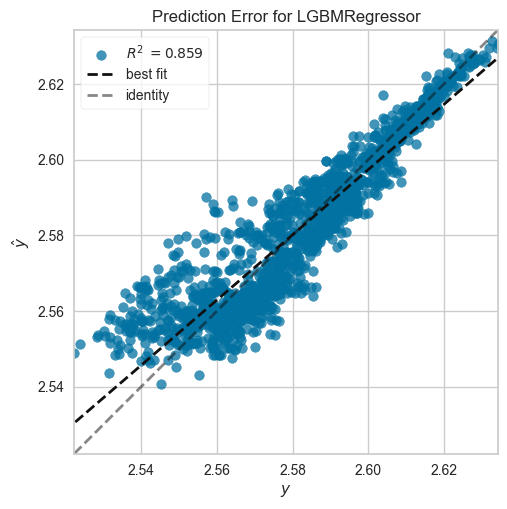

In [31]:
plot_model(tuned_best, plot = 'error')

In [32]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Evaluate model with test data

Before finalizing the model, it is recommended to perform a final check by predicting the test set and reviewing the evaluation metrics. All of the evaluation metrics we've seen above are cross-validated results based **only on the training set (70%)**. Now, we are going to use the test data to see if the performance is different and there may be overfitting.

In [33]:
predict_model(tuned_best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1663.0680,5695398.9005,2386.5035,0.9481,0.2233,0.1835


### Finish to put into production

In [34]:
# finalize the model
final_best = finalize_model(tuned_best)

# save model to disk
save_model(final_best, 'diamond-pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\WMYFHCK\AppData\Local\Temp\joblib),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['Carat Weight'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerW...
                  TransformerWrapper(include=['Carat Weight'],
                                     transformer=KBinsDiscretizer(encode='ordinal',
                                                                  strategy='kmeans'))),
                 ('transformation',
                  TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('clean_column_names',
                  Tra

### Predictions with unseen data

In [35]:
unseen_predictions = predict_model(final_best, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1707.3372,6413577.3322,2532.5042,0.9377,0.2202,0.1802


,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,prediction_label
0,1.53,Ideal,E,SI1,ID,ID,AGSL,2.657130,10512.192162
1,1.50,Fair,F,SI1,VG,VG,GIA,2.650441,10658.978702
2,1.01,Good,E,SI1,G,G,GIA,2.622831,4679.748196
3,2.51,Very Good,G,VS2,VG,VG,GIA,2.683593,33204.129546
4,1.01,Good,I,SI1,VG,VG,GIA,2.613765,3804.655310


### Due to some reason, the Prices are getting modified but the real prices are given below

In [41]:
data_unseen.head()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.53,Ideal,E,SI1,ID,ID,AGSL,12791
1,1.50,Fair,F,SI1,VG,VG,GIA,10450
2,1.01,Good,E,SI1,G,G,GIA,5161
3,2.51,Very Good,G,VS2,VG,VG,GIA,34361
4,1.01,Good,I,SI1,VG,VG,GIA,4238


In [46]:
unseen_predictions.loc[:, "Price"] = data_unseen["Price"]
unseen_predictions.head()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,prediction_label
0,1.53,Ideal,E,SI1,ID,ID,AGSL,12791,10512.192162
1,1.50,Fair,F,SI1,VG,VG,GIA,10450,10658.978702
2,1.01,Good,E,SI1,G,G,GIA,5161,4679.748196
3,2.51,Very Good,G,VS2,VG,VG,GIA,34361,33204.129546
4,1.01,Good,I,SI1,VG,VG,GIA,4238,3804.655310


In [47]:
from pycaret.utils import generic
generic.check_metric(unseen_predictions.Price, unseen_predictions.prediction_label, 'R2')

0.9377